In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, chain
import tqdm
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.autograd import Variable



from nosaveddata.builders.mlp import *
from nosaveddata.builders.weight_init import *
from nosaveddata.nsd_utils.networks import params_count, params_and_grad_norm, seed_np_torch
from nosaveddata.builders.resnet import IMPALA_Resnet, DQN_Conv


from utils.experience_replay import *


import locale
locale.getpreferredencoding = lambda: "UTF-8"



import wandb
wandb.init(
    project="Atari-100k",
    name=f"BBF",

    #id='rotdmtc5',
    #resume='must',

    config={
        "learning_rate": 1e-4,
        "architecture": "BBF",
        "dataset": "Assault",
        "epochs": 100,
    },

    reinit=False
)


# Environment configuration
env_name = 'Assault'
SEED = 7783


# Optimization
batch_size = 32
lr=1e-4

eps=1e-8


# Target network EMA rate
critic_ema_decay=0.995


# Return function
initial_gamma=torch.tensor(1-0.97).log()
final_gamma=torch.tensor(1-0.997).log()

initial_n = 10
final_n = 3

num_buckets=51


# Reset Schedule and Buffer
reset_every=40000 # grad steps, not steps.
schedule_max_step=reset_every//4
total_steps=100000

prefetch_cap=1 # actually, no prefetch is being done


Transition = namedtuple('Transition',
                        ('state', 'reward', 'action', 'c_flag'))
memory = PrioritizedReplay_nSteps_Sqrt(100005, total_steps=schedule_max_step, prefetch_cap=prefetch_cap)



def save_checkpoint(net, model_target, optimizer, step, path):
    torch.save({
            'model_state_dict': net.state_dict(),
            'model_target_state_dict': model_target.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'step': step,
            }, path)


C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sneep\anaconda3\envs\python_\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
wandb: Currently logged in as: snykralafk. Use `wandb login --relogin` to force relogin


In [5]:
class MaxLast2FrameSkipWrapper(gym.Wrapper):
    def __init__(self, env, skip=4, seed=0):
        super().__init__(env)
        self.seed = seed
        self.skip = skip
        self.env.action_space.seed(seed)
        
    def reset(self, **kwargs):
        kwargs["seed"] = self.seed
        obs, _ = self.env.reset(**kwargs)
        return obs, _

    def step(self, action):
        total_reward = 0
        self.obs_buffer = deque(maxlen=2)
        for _ in range(self.skip):
            obs, reward, done, truncated, info = self.env.step(action)
            self.obs_buffer.append(obs)
            total_reward += reward

            terminated = np.logical_or(done, truncated)
            #if terminated.any():
            #    for i in range(len(terminated)):
            #       obs[i] = self.reset()[0][i]
            if done or truncated:
                break
        if len(self.obs_buffer) == 1:
            obs = self.obs_buffer[0]
        else:
            obs = np.max(np.stack(self.obs_buffer), axis=0)
        return obs, total_reward, done, truncated, info


env = gym.vector.make(f"{env_name}NoFrameskip-v4", num_envs=1)
env = MaxLast2FrameSkipWrapper(env,seed=SEED)


#n_actions = env.action_space.n
n_actions = env.action_space[0].n

state, info = env.reset()
n_observations = len(state)

seed_np_torch(SEED)

In [6]:

def renormalize(tensor, has_batch=False):
    shape = tensor.shape
    tensor = tensor.view(tensor.shape[0], -1)
    max_value,_ = torch.max(tensor, -1, keepdim=True)
    min_value,_ = torch.min(tensor, -1, keepdim=True)
    return ((tensor - min_value) / (max_value - min_value + 1e-5)).view(shape)


class DQN(nn.Module):
    def __init__(self, n_actions, hiddens=2048, mlp_layers=1, scale_width=4,
                 n_atoms=51, Vmin=-10, Vmax=10):
        super().__init__()
        self.support = torch.linspace(Vmin, Vmax, n_atoms).cuda()
        
        self.hiddens=hiddens
        self.scale_width=scale_width
        self.act = nn.ReLU()
        
        
        self.encoder_cnn = IMPALA_Resnet(scale_width=scale_width, norm=False, init=init_relu, act=self.act)
        
        
        #self.projection = MLP(10368, med_hiddens=hiddens, out_hiddens=hiddens,
        self.projection = MLP(13824, med_hiddens=hiddens, out_hiddens=hiddens,
                              in_act=nn.Identity(), init=init_xavier,
                              last_init=init_relu, layers=1)
        self.prediction = MLP(hiddens, out_hiddens=hiddens, layers=1, last_init=init_relu)
                                              
        self.transition = nn.Sequential(DQN_Conv(128+n_actions, 128, 3, 1, 1, norm=False, init=init_xavier, act=self.act),
                                        DQN_Conv(128, 128, 3, 1, 1, norm=False, init=init_relu, act=self.act))


        self.a = MLP(hiddens, out_hiddens=n_actions*num_buckets, layers=1, in_act=self.act, last_init=init_orth)
        self.v = MLP(hiddens, out_hiddens=num_buckets, layers=1, in_act=self.act, last_init=init_orth)
    
        params_count(self, 'DQN')
    
    def forward(self, X, y_action):
        X, z = self.encode(X)
        
        
        q, action = self.q_head(X)
        z_pred = self.get_transition(z, y_action)

        return q, action, X[:,1:].clone().detach(), z_pred
    

    def env_step(self, X):
        with torch.no_grad():
            X, _ = self.encode(X)
            _, action = self.q_head(X)
            
            return action.detach()
    

    def encode(self, X):
        batch, seq = X.shape[:2]
        self.batch = batch
        self.seq = seq
        X = self.encoder_cnn(X.contiguous().view(self.batch*self.seq, *(X.shape[2:])))
        X = renormalize(X).contiguous().view(self.batch, self.seq, *X.shape[-3:])
        X = X.contiguous().view(self.batch, self.seq, *X.shape[-3:])
        z = X.clone()
        X = X.flatten(-3,-1)
        X = self.projection(X)
        return X, z

    def get_transition(self, z, action):
        z = z.contiguous().view(-1, *z.shape[-3:])
        
        action = F.one_hot(action.clone(), n_actions).view(-1, n_actions)
        action = action.view(-1, 5, n_actions, 1, 1).expand(-1, 5, n_actions, *z.shape[-2:])

        
        z_pred = torch.cat( (z, action[:,0]), 1)
        z_pred = self.transition(z_pred)
        z_pred = renormalize(z_pred)
        
        z_preds=[z_pred.clone()]
        

        for k in range(4):
            z_pred = torch.cat( (z_pred, action[:,k+1]), 1)
            z_pred = self.transition(z_pred)
            z_pred = renormalize(z_pred)
            
            z_preds.append(z_pred)
        
        
        z_pred = torch.stack(z_preds,1)

        z_pred = self.projection(z_pred.flatten(-3,-1)).view(self.batch,5,-1)
        z_pred = self.prediction(z_pred)
        
        return z_pred

    
    def q_head(self, X):
        q = self.dueling_dqn(X)
        action = (q*self.support).sum(-1).argmax(-1)
        
        return q, action

    def get_max_action(self, X):
        with torch.no_grad():
            X, _ = self.encode(X)
            q = self.dueling_dqn(X)
            
            action = (q*self.support).sum(-1).argmax(-1)
            return action

    def evaluate(self, X, action):
        with torch.no_grad():
            X, _ = self.encode(X)
            
            q = self.dueling_dqn(X)
            
            action = action[:,:,None,None].expand_as(q)[:,:,0][:,:,None]
            q = q.gather(-2,action)
            
            return q

    def dueling_dqn(self, X):
        X = F.relu(X)
        
        a = self.a(X).view(self.batch, -1, n_actions, num_buckets)
        v = self.v(X).view(self.batch, -1, 1, num_buckets)
        
        q = v + a - a.mean(-2,keepdim=True)
        q = F.softmax(q,-1)
        
        return q
    
    def network_ema(self, rand_network, target_network, alpha=0.5):
        for param, param_target in zip(rand_network.parameters(), target_network.parameters()):
            param_target.data = alpha * param_target.data + (1 - alpha) * param.data.clone()

    def hard_reset(self, random_model, alpha=0.5):
        with torch.no_grad():
            
            self.network_ema(random_model.encoder_cnn, self.encoder_cnn, alpha)
            self.network_ema(random_model.transition, self.transition, alpha)

            self.network_ema(random_model.projection, self.projection, 0)
            self.network_ema(random_model.prediction, self.prediction, 0)

            self.network_ema(random_model.a, self.a, 0)
            self.network_ema(random_model.v, self.v, 0)



def copy_states(source, target):
    for key, _ in zip(source.state_dict()['state'].keys(), target.state_dict()['state'].keys()):

        target.state_dict()['state'][key]['exp_avg_sq'] = copy.deepcopy(source.state_dict()['state'][key]['exp_avg_sq'])
        target.state_dict()['state'][key]['exp_avg'] = copy.deepcopy(source.state_dict()['state'][key]['exp_avg'])
        target.state_dict()['state'][key]['step'] = copy.deepcopy(source.state_dict()['state'][key]['step'])
        
def target_model_ema(model, model_target):
    with torch.no_grad():
        for param, param_target in zip(model.parameters(), model_target.parameters()):
            param_target.data = critic_ema_decay * param_target.data + (1.0 - critic_ema_decay) * param.data.clone()


    
model=DQN(n_actions).cuda()
model_target=DQN(n_actions).cuda()

model_target.load_state_dict(model.state_dict())


# Testing only
#with torch.no_grad():
#    q, action, X, z_pred = model(torch.randn(4,1,12,96,72, device='cuda', dtype=torch.float), torch.randint(0,n_actions,(4,5),device='cuda').long())
#z = model.encode(torch.randn(4,5,12,96,72, device='cuda'))[0]

IMPALA ResNet Parameters: 1.56M
DQN Parameters: 35.21M
IMPALA ResNet Parameters: 1.56M
DQN Parameters: 35.21M


<All keys matched successfully>

In [7]:
perception_modules=[model.encoder_cnn, model.transition]
actor_modules=[model.prediction, model.projection, model.a, model.v]

params_wm=[]
for module in perception_modules:
    for param in module.parameters():
        if param.requires_grad==True: # They all require grad
            params_wm.append(param)

params_ac=[]
for module in actor_modules:
    for param in module.parameters():
        if param.requires_grad==True:
            params_ac.append(param)


optimizer = torch.optim.AdamW(chain(params_wm, params_ac),
                                lr=lr, weight_decay=0.1, eps=1.5e-4)


#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr*1.2,
#                     total_steps=100000//initial_n//batch_size*16)


params_to_count = [p for p in model.parameters() if p.requires_grad]
print()
print(f'Model number of parameters: {sum(p.numel() for p in params_to_count)/1e6:.2f}M')
print()



Model number of parameters: 35.21M



In [8]:
import torchvision.transforms as transforms

train_tfms = transforms.Compose([
                         transforms.Resize((96,72)),
                        ])


def preprocess(state):
    state=torch.tensor(state, dtype=torch.float, device='cuda') / 255
    state=train_tfms(state.permute(0,3,1,2))
    return state


def linearly_decaying_epsilon(decay_period, step, warmup_steps, epsilon):
    steps_left = decay_period + warmup_steps - step
    bonus = (1.0 - epsilon) * steps_left / decay_period
    bonus = np.clip(bonus, 0., 1. - epsilon)
    return epsilon + bonus


def epsilon_greedy(Q_action, step, final_eps=0, num_envs=1):
    epsilon = linearly_decaying_epsilon(2001, step, 2000, final_eps)
    
    if random.random() < epsilon:
        action = torch.randint(0, n_actions, (num_envs,), dtype=torch.int64, device='cuda').squeeze(0)
    else:
        action = Q_action.view(num_envs).squeeze(0).to(torch.int64)
    return action


In [ ]:
# https://github.com/google/dopamine/blob/master/dopamine/jax/agents/rainbow/rainbow_agent.py
def project_distribution(supports, weights, target_support):
    with torch.no_grad():
        v_min, v_max = target_support[0], target_support[-1]
        # `N` in Eq7.
        num_dims = target_support.shape[-1]
        # delta_z = `\Delta z` in Eq7.
        delta_z = (v_max - v_min) / (num_buckets-1)
        # clipped_support = `[\hat{T}_{z_j}]^{V_max}_{V_min}` in Eq7.
        clipped_support = supports.clip(v_min, v_max)
        # numerator = `|clipped_support - z_i|` in Eq7.
        numerator = (clipped_support[:,None] - target_support[None,:,None].repeat_interleave(clipped_support.shape[0],0)).abs()
        quotient = 1 - (numerator / delta_z)
        # clipped_quotient = `[1 - numerator / (\Delta z)]_0^1` in Eq7.
        clipped_quotient = quotient.clip(0, 1)
        # inner_prod = `\sum_{j=0}^{N-1} clipped_quotient * p_j(x', \pi(x'))` in Eq7.
        inner_prod = (clipped_quotient * weights[:,None]).sum(-1)
        #inner_prod = (clipped_quotient).sum(-1) * weights
        return inner_prod.squeeze()


mse = torch.nn.MSELoss(reduction='none')


scaler = torch.cuda.amp.GradScaler()
def optimize(step, grad_step, n):
        
    model.train()
    #model_target.eval()
    model_target.train()

    with torch.autocast(device_type='cuda', dtype=torch.bfloat16, enabled=False):
        with torch.no_grad():
            states, next_states, rewards, action, c_flag, idxs, is_w = memory.sample(n, batch_size, grad_step)
        terminal=1-c_flag
        #print(f"STUFF HERE {states.shape, rewards.shape, c_flag.shape, action.shape, n}")
    
    
        q, max_action, z, z_pred = model(states[:,0][:,None], action[:,:5].long())
        z = model_target.encode(states[:,1:6])[0].detach()

        # They actually use n-1 for next states.
        max_action  = model.get_max_action(next_states[:,n][:,None])
        next_values = model_target.evaluate(next_states[:,n][:,None].contiguous(), max_action)
        

        action = action[:,0,None].expand(batch_size,num_buckets)
        action=action[:,None]
        with torch.no_grad():
            gammas_one=torch.ones(batch_size,n,1,dtype=torch.float,device='cuda')
            gamma_step = 1-torch.tensor(( (schedule_max_step - min(grad_step, schedule_max_step)) / schedule_max_step) * (initial_gamma-final_gamma) + final_gamma).exp()
            gammas=gammas_one*gamma_step

            
            returns = []
            for t in range(n):
                ret = 0
                for u in reversed(range(t, n)):
                    ret += torch.prod(c_flag[:,t+1:u+1],-2)*torch.prod(gammas[:,t:u],-2)*rewards[:,u+1]
                returns.append(ret)
            returns = torch.stack(returns,1)
        
        plot_vs = returns.clone().sum(-1)
        
        same_traj = (torch.prod(c_flag[:,:n],-2)).squeeze()
        
        returns = returns[:,0]
        returns = returns + torch.prod(gammas[0,:10],-2).squeeze()*same_traj[:,None]*model.support[None,:]
        returns = returns.squeeze()
        
        next_values = next_values[:,0]

        log_probs = torch.log(q[:,0].gather(-2, action)[:,None] + eps).contiguous()
        
        
        dist = project_distribution(returns, next_values.squeeze(), model.support)
        
        loss = -(dist*(log_probs.squeeze())).sum(-1).view(batch_size,-1).sum(-1)
        dqn_loss = loss.clone().mean()
        td_error = (loss + torch.nan_to_num((dist*torch.log(dist))).sum(-1)).mean()

        
        batched_loss = loss.clone()
        
        
        z = F.normalize(z, 2, dim=-1, eps=1e-5)
        z_pred = F.normalize(z_pred, 2, dim=-1, eps=1e-5)

        #z_mask = z_mask[:,:,:5]
        #z_mask = z_mask.contiguous().view(5,-1).cuda()
        #recon_loss = (mse(z_pred.contiguous().view(5,-1,2048), z.contiguous().view(-1,2048).unsqueeze(0).repeat_interleave(5,0))).sum(-1)*z_mask
        #recon_loss = 5*((recon_loss.mean(0).view(batch_size,-1))*same_traj[:,None]).sum(-1)
        
        recon_loss = (mse(z_pred.contiguous().view(-1,2048), z.contiguous().view(-1,2048))).sum(-1)
        recon_loss = 5*(recon_loss.view(batch_size, -1).mean(-1))*same_traj
        
        
        loss += recon_loss
        
        loss = (loss*is_w).mean() # mean across batch axis

    loss.backward()

    param_norm, grad_norm = params_and_grad_norm(model)
    #scaler.scale(loss).backward()
    #scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
    #scaler.step(optimizer)
    #scaler.update()
    
    optimizer.step()
    optimizer.zero_grad()
    
    #memory.set_priority(idxs, batched_loss)
    memory.set_priority(idxs, batched_loss, same_traj)
    
    
    lr = optimizer.param_groups[0]['lr']
    wandb.log({'loss': loss, 'dqn_loss': dqn_loss, 'recon_loss': recon_loss.mean(), 'lr': lr, 'returns': plot_vs.mean(),
               'rewards': rewards.mean(0).sum(), 'is_w': is_w.mean(),
               'gamma': gamma_step, 'td_error': td_error, 'param_norm': param_norm.sum(), 'grad_norm': grad_norm.sum()})




scores=[]
memory.free()
step=0
#model.share_memory()
grad_step=0

In [7]:
step=0

progress_bar = tqdm.tqdm(total=100002)

while step<(10):
    state, info = env.reset()
    state = preprocess(state)

    stacked = state.repeat_interleave(3,1)
    state = torch.cat((stacked.clone(), state),1)
    
    
    eps_reward=torch.tensor([0], dtype=torch.float)
    
    reward=np.array([0])
    done_flag=np.array([False])
    terminated=np.array([False])

    last_lives=np.array([0])
    life_loss=np.array([0])
    
    last_grad_update=0
    while step<(total_steps):
        progress_bar.update(1)
        model_target.train()
        
        len_memory = len(memory)
        Q_action = model_target.env_step(state.unsqueeze(0))
        
        action = epsilon_greedy(Q_action, len_memory).cpu()
        
        memory.push(state.detach().cpu(), reward, action, np.logical_or(done_flag, life_loss))
        #print('action', action, action.shape)
        
        state, reward, terminated, truncated, info = env.step([action.numpy()])
        
        state = preprocess(state)
        eps_reward+=reward
        reward = reward.clip(-1, 1)

        state = torch.cat((stacked.clone(), state),1)
        stacked = torch.cat((stacked[:,3:], state[:,-3:]),1)

        
        done_flag = np.logical_or(terminated, truncated)
        lives = info['lives']
        life_loss = (last_lives-lives).clip(min=0)
        last_lives = lives

        
        n = int(initial_n * (final_n/initial_n)**(min(grad_step,schedule_max_step) / schedule_max_step))
        n = np.array(n).item()
        
        memory.priority[len_memory] = memory.max_priority()
        

        if len_memory>2000:
            for i in range(2):
                optimize(step, grad_step, n)
                target_model_ema(model, model_target)
                grad_step+=1

        
        if ((step+1)%10000)==0:
            save_checkpoint(model, model_target, optimizer, step,
                            'checkpoints/atari_last.pth')
        
            
        
        if grad_step>reset_every:
            #eval()
            print('Reseting on step', step, grad_step)
            
            seed_np_torch(random.randint(SEED-1000, SEED+1000))
            random_model = DQN(n_actions).cuda()
            model.hard_reset(random_model)
            
            seed_np_torch(random.randint(SEED-1000, SEED+1000))
            random_model = DQN(n_actions).cuda()
            model_target.hard_reset(random_model)
            seed_np_torch(SEED)
            
            random_model=None
            grad_step=0

            actor_modules=[model.prediction, model.projection, model.a, model.v]
            params_ac=[]
            for module in actor_modules:
                for param in module.parameters():
                    params_ac.append(param)
                    

            perception_modules=[model.encoder_cnn, model.transition]
            params_wm=[]
            for module in perception_modules:
                for param in module.parameters():
                    params_wm.append(param)
            
            optimizer_aux = torch.optim.AdamW(params_wm, lr=lr, weight_decay=0.1, eps=1.5e-4)
            copy_states(optimizer, optimizer_aux)
            optimizer = torch.optim.AdamW(chain(params_wm, params_ac),
                                lr=lr, weight_decay=0.1, eps=1.5e-4)
            copy_states(optimizer_aux, optimizer)
            
        
        
        step+=1
        
        log_t = done_flag.astype(float).nonzero()[0]
        
        if len(log_t)>0:
            for log in log_t:
                wandb.log({'eps_reward': eps_reward[log].sum()})
                scores.append(eps_reward[log].clone())
            eps_reward[log_t]=0

save_checkpoint(model, model_target, optimizer, step, f'checkpoints/{env_name}.pth')

  2%|▏         | 1975/100002 [00:07<05:14, 311.72it/s]C:\Users\sneep\AppData\Local\Temp\ipykernel_5152\2221393133.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_step = 1-torch.tensor(( (schedule_max_step - min(grad_step, schedule_max_step)) / schedule_max_step) * (initial_gamma-final_gamma) + final_gamma).exp()
  6%|▋         | 6438/100002 [11:31<3:33:54,  7.29it/s]
KeyboardInterrupt



In [11]:
load_to_eval=True

if load_to_eval:
    model.load_state_dict(torch.load(f'checkpoints/{env_name}.pth')['model_state_dict'])
    model_target.load_state_dict(torch.load(f'checkpoints/{env_name}.pth')['model_target_state_dict'])



  0%|          | 0/100 [00:00<?, ?it/s]

init state torch.Size([1, 3, 96, 72])




  1%|          | 1/100 [00:28<46:44, 28.33s/it]

  2%|▏         | 2/100 [00:37<27:43, 16.97s/it]

  3%|▎         | 3/100 [00:45<21:15, 13.15s/it]

  4%|▍         | 4/100 [00:54<17:59, 11.25s/it]

  5%|▌         | 5/100 [01:17<24:41, 15.59s/it]

  6%|▌         | 6/100 [01:24<19:56, 12.73s/it]

  7%|▋         | 7/100 [01:52<27:30, 17.75s/it]

  8%|▊         | 8/100 [02:18<31:16, 20.40s/it]

  9%|▉         | 9/100 [02:48<35:19, 23.29s/it]

 10%|█         | 10/100 [02:59<29:17, 19.53s/it]

 11%|█         | 11/100 [03:27<32:41, 22.04s/it]

 12%|█▏        | 12/100 [03:55<34:52, 23.78s/it]

 13%|█▎        | 13/100 [04:21<35:38, 24.58s/it]

 14%|█▍        | 14/100 [04:30<28:20, 19.78s/it]

 15%|█▌        | 15/100 [04:44<25:34, 18.05s/it]

 16%|█▌        | 16/100 [05:11<29:16, 20.91s/it]

 17%|█▋        | 17/100 [05:25<25:46, 18.63s/it]

 18%|█▊        | 18/100 [05:34<21:29, 15.73s/it]

 19%|█▉        | 19/100 [05:56<23:57, 17.74s/it]

 20%|██        | 20/100 [06:03<19:24, 14.56s/it]

 21%|██

Scores Mean 1918.73
Inter Quantile Mean 1905.32
Inter Quantile STD 764.6072872223161


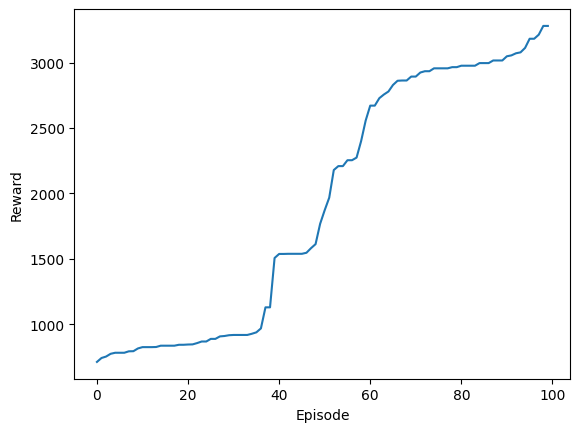

In [27]:
import matplotlib.pyplot as plt

num_envs=1

#env = gym.vector.make(f"AssaultNoFrameskip-v4", num_envs=num_envs, render_mode='human')
env = gym.vector.make(f"{env_name}NoFrameskip-v4", num_envs=num_envs)
env = MaxLast2FrameSkipWrapper(env,seed=SEED)

def eval_phase(eval_runs=50, max_eval_steps=27000, num_envs=1):
    progress_bar = tqdm.tqdm(total=eval_runs)
    
    scores=[]
    
    state, info = env.reset()
    state = preprocess(state)
    print(f"init state {state.shape}")
    stacked = state.repeat_interleave(3,1)
    state = torch.cat((stacked.clone(), state),1)
    
    
    eps_reward=torch.tensor([0]*num_envs, dtype=torch.float)
    
    reward=np.array([0]*num_envs)
    terminated=np.array([False]*num_envs)

    last_lives=np.array([0]*num_envs)

    finished_envs=np.array([False]*num_envs)
    done_flag=0
    last_grad_update=0
    eval_run=0
    step=np.array([0]*num_envs)
    while eval_run<eval_runs:
        seed_np_torch(SEED+eval_run)
        #env.seed=SEED+eval_run

        model.train()
        model_target.train()
        
        Q_action = model_target.env_step(state.unsqueeze(0))
        action = epsilon_greedy(Q_action.squeeze(), 5000, 0.0005, num_envs).cpu()
        
        state, reward, terminated, truncated, info = env.step([action.numpy()] if num_envs==1 else action.numpy())
        done_flag = np.logical_or(terminated, truncated)
        

        state = preprocess(state)
        eps_reward+=reward


        
        state = torch.cat((stacked.clone(), state),1)
        stacked = torch.cat((stacked[:,3:], state[:,-3:]),1)
        
        
        step+=1
        
        log_t = done_flag.astype(float).nonzero()[0]
        if len(log_t)>0:# or (step>max_eval_steps).any():
            progress_bar.update(1)
            for log in log_t:
                #wandb.log({'eval_eps_reward': eps_reward[log].sum()})
                if finished_envs[log]==False:
                    scores.append(eps_reward[log].clone())
                    eval_run+=1
                    #finished_envs[log]=True
                step[log]=0
                
            eps_reward[log_t]=0            
            for i, log in enumerate(step>max_eval_steps):
                if log==True and finished_envs[i]==False:
                    scores.append(eps_reward[i].clone())
                    step[i]=0
                    eval_run+=1
                    eps_reward[i]=0
                    #finished_envs[i]=True
            
    return scores



def eval(eval_runs=50, max_eval_steps=27000, num_envs=1):
    assert num_envs==1, 'The code for num eval envs > 1 is messed up.'
    
    scores = eval_phase(eval_runs, max_eval_steps, num_envs)    
    scores = torch.stack(scores)
    scores, _ = scores.sort()
    
    _25th = eval_runs//4

    iq = scores[_25th:-_25th]
    iqm = iq.mean()
    iqs = iq.std()

    print(f"Scores Mean {scores.mean()}")
    print(f"Inter Quantile Mean {iqm}")
    print(f"Inter Quantile STD {iqs}")

    
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(scores)
    
    return scores

scores = eval(eval_runs=100, num_envs=1)